In [1]:
import sys
sys.path.append('../')

from src.m4_generator import M4Generator
from src.m4_data_loader import M4DataLoader
from src.error_functions import *
from src.visualization import *
from src.evaluation import *
from src.m4_model import M4Model


import numpy as np
import keras
import matplotlib.pyplot as plt

import tensorflow as tf

%matplotlib inline
keras.backend.set_floatx('float64')

Using TensorFlow backend.


# Load Data

In [2]:
EPOCHS = 200
BATCH_SIZE = 128
LOOKBACK = 48
HORIZON = 48
HIDDEN_LAYER_SIZE = 20
FEATURES_NUMBER = 2
OUTPUT_SIZE = HORIZON*2
PI_CONFEDENCE=1.1
STD_WEIGHT = 1
LOSS = kl_divergance
PI_PARAMS = {'max_coff': 0.25, 'min_coff': 0.15, 'step': 0.1}

data_loader = M4DataLoader("../Dataset/Train/Hourly-train.csv", "../Dataset/Test/Hourly-test.csv",
                  LOOKBACK, HORIZON,  validation_ratio=0.05, pi_params=PI_PARAMS)

train_x, train_y = data_loader.get_training_data()
test_x, test_y = data_loader.get_test_data()
validate_x, validate_y = data_loader.get_validation_data()

training_data_generator = M4Generator(train_x, train_y, BATCH_SIZE, FEATURES_NUMBER)
test_data_generator = M4Generator(test_x, test_y, BATCH_SIZE, FEATURES_NUMBER)
validation_data_generator = M4Generator(validate_x, validate_y, BATCH_SIZE, FEATURES_NUMBER)

-1.1232156668806597
-1.3586846548012366
-0.8877466789600827


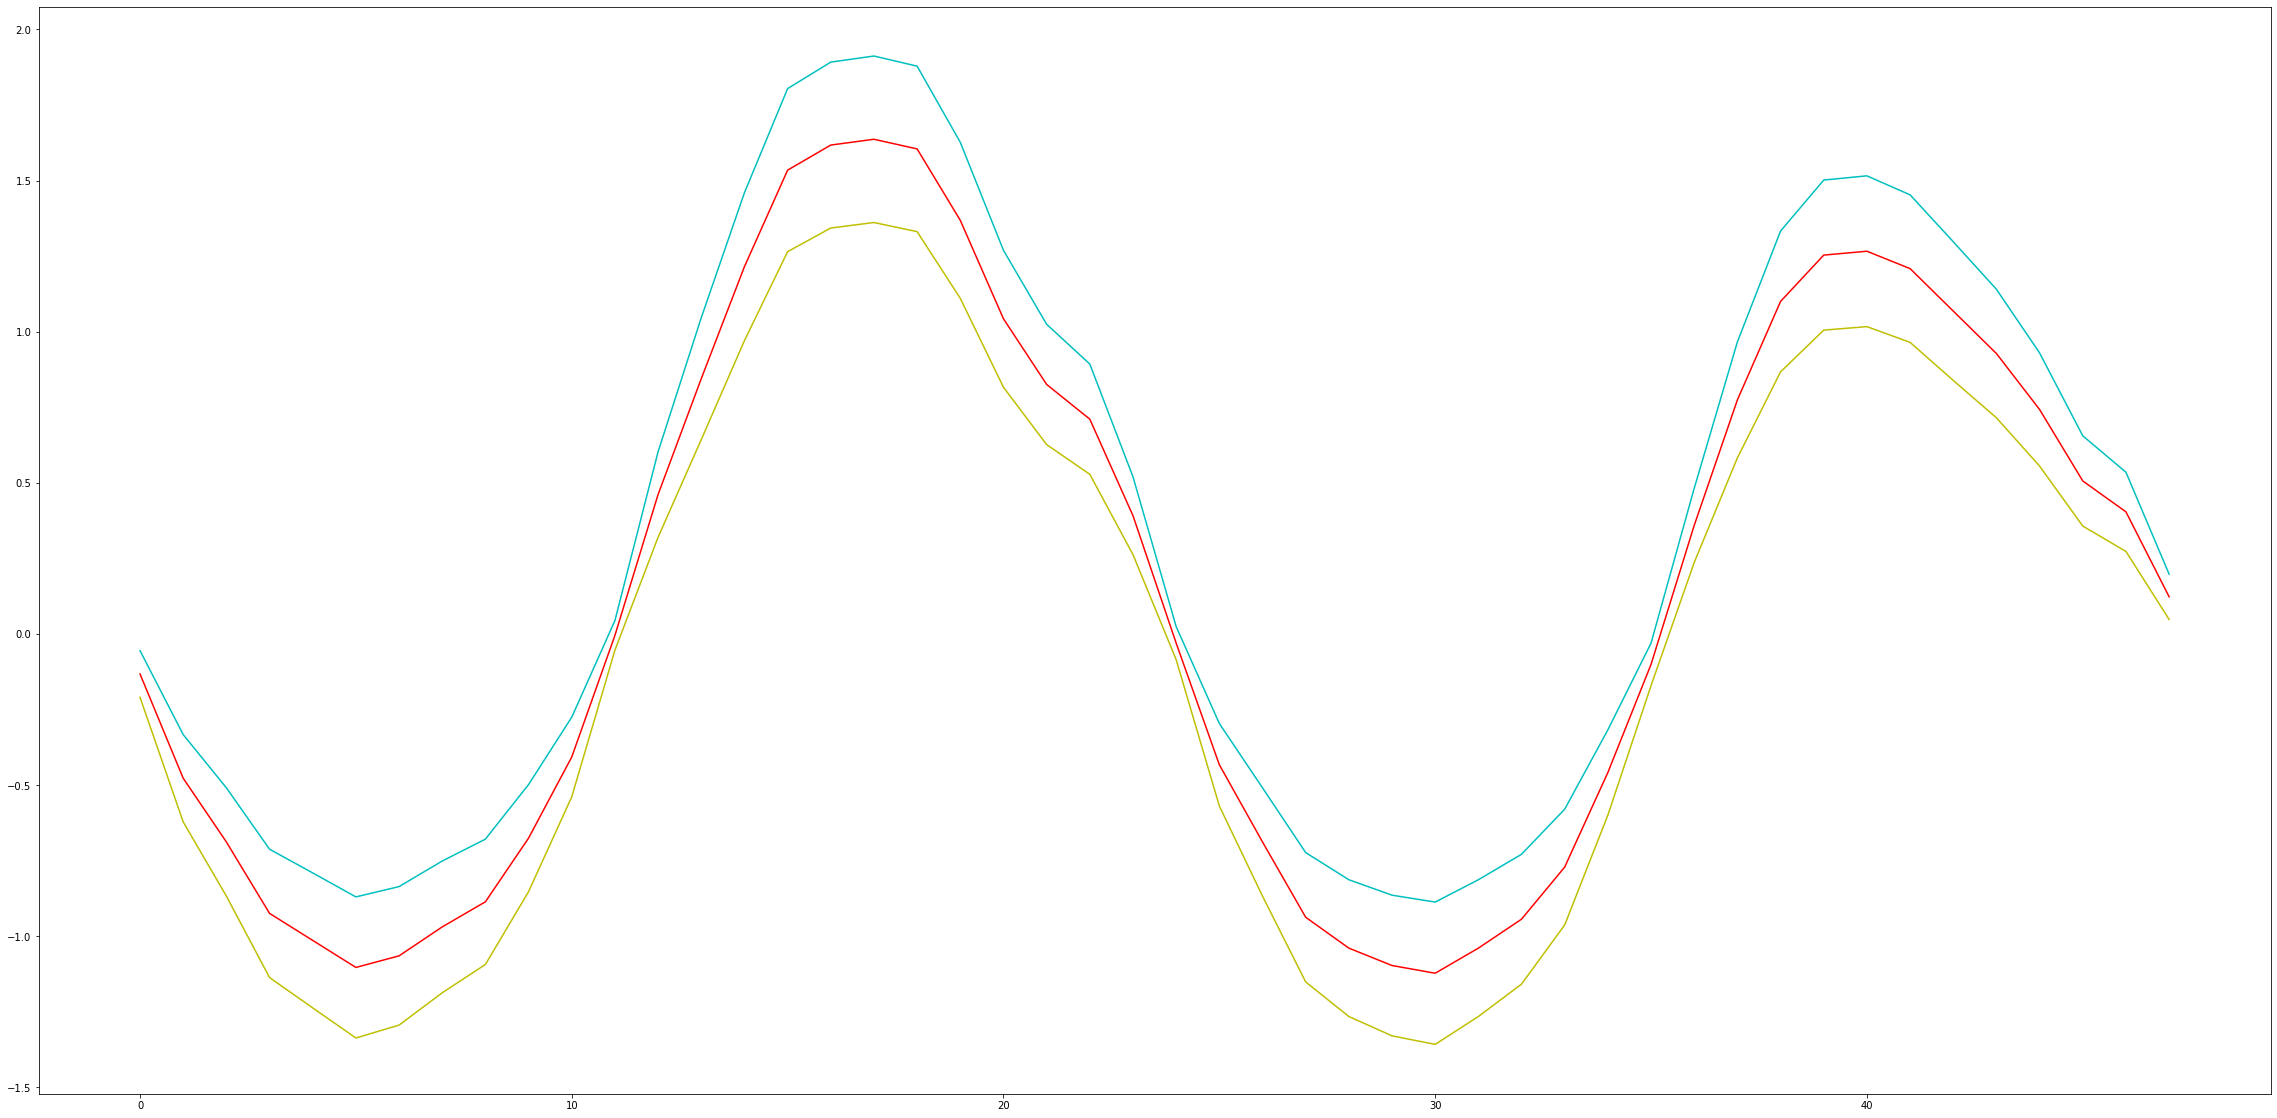

In [18]:

fig, axs = plt.subplots(1, 1, figsize=(40, 20))
    
true_series_time_axes = np.arange(0, 48)
axs.plot(true_series_time_axes, test_y[0,:48], color='r')
axs.plot(true_series_time_axes, test_y[0,:48] - test_y[0,48:], color='y')
axs.plot(true_series_time_axes, test_y[0,:48] + test_y[0,48:], color='c')

print(test_y[0,:48].min() )
print( (test_y[0,:48] - test_y[0,48:]).min())
print( (test_y[0,:48] + test_y[0,48:]).min())

In [19]:
from keras.callbacks.callbacks import Callback

class EarlyStoppingByLossVal(Callback):
    def __init__(self, monitor='val_loss', value=0.00001, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current < self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True

# Train The Model

In [20]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=10,
                              verbose=0, mode='auto')
callback1 = EarlyStoppingByLossVal(monitor='val_loss', value=0.5, verbose=1)

model = M4Model(hidden_layer_size=HIDDEN_LAYER_SIZE, batch_size=BATCH_SIZE, lookback=LOOKBACK, 
                output_size=OUTPUT_SIZE, learning_rate=0.01, loss = LOSS,
                dropout_ratio = 0.3, features_number = FEATURES_NUMBER, callbacks = [callback1], pi_params=PI_PARAMS)

In [23]:
model.train(training_data_generator, test_data_generator, epochs=EPOCHS)

hist = model.evaluate(validation_data_generator)
print(hist)

Epoch 1/200
50/50 [==============================] - 4s 83ms/step - loss: 0.6835 - val_loss: 0.6967
Epoch 2/200
50/50 [==============================] - 4s 83ms/step - loss: 0.6790 - val_loss: 0.7088
Epoch 3/200
50/50 [==============================] - 4s 81ms/step - loss: 0.6815 - val_loss: 0.7046
Epoch 4/200
50/50 [==============================] - 4s 82ms/step - loss: 0.6798 - val_loss: 0.7258
Epoch 5/200
50/50 [==============================] - 4s 88ms/step - loss: 0.6778 - val_loss: 0.7093
Epoch 6/200
50/50 [==============================] - 4s 87ms/step - loss: 0.6778 - val_loss: 0.7213
Epoch 7/200
50/50 [==============================] - 4s 90ms/step - loss: 0.6788 - val_loss: 0.7146
Epoch 8/200
50/50 [==============================] - 4s 87ms/step - loss: 0.6773 - val_loss: 0.7031
Epoch 9/200
50/50 [==============================] - 4s 87ms/step - loss: 0.6753 - val_loss: 0.6932
Epoch 10/200
50/50 [==============================] - 4s 88ms/step - loss: 0.6760 - val_loss: 0.7077

50/50 [==============================] - 4s 88ms/step - loss: 0.6613 - val_loss: 0.6905
Epoch 83/200
50/50 [==============================] - 5s 90ms/step - loss: 0.6608 - val_loss: 0.7002
Epoch 84/200
50/50 [==============================] - 4s 88ms/step - loss: 0.6609 - val_loss: 0.6891
Epoch 85/200
50/50 [==============================] - 4s 88ms/step - loss: 0.6621 - val_loss: 0.6858
Epoch 86/200
50/50 [==============================] - 4s 87ms/step - loss: 0.6638 - val_loss: 0.6825
Epoch 87/200
50/50 [==============================] - 5s 90ms/step - loss: 0.6619 - val_loss: 0.6889
Epoch 88/200
50/50 [==============================] - 4s 87ms/step - loss: 0.6606 - val_loss: 0.6967
Epoch 89/200
50/50 [==============================] - 5s 105ms/step - loss: 0.6627 - val_loss: 0.6936
Epoch 90/200
50/50 [==============================] - 4s 90ms/step - loss: 0.6599 - val_loss: 0.6867
Epoch 91/200
50/50 [==============================] - 5s 93ms/step - loss: 0.6598 - val_loss: 0.6879
Ep

50/50 [==============================] - 5s 94ms/step - loss: 0.6517 - val_loss: 0.6810
Epoch 163/200
50/50 [==============================] - 5s 94ms/step - loss: 0.6506 - val_loss: 0.6852
Epoch 164/200
50/50 [==============================] - 4s 85ms/step - loss: 0.6475 - val_loss: 0.6861
Epoch 165/200
50/50 [==============================] - 4s 82ms/step - loss: 0.6518 - val_loss: 0.6798
Epoch 166/200
50/50 [==============================] - 4s 82ms/step - loss: 0.6501 - val_loss: 0.6763
Epoch 167/200
50/50 [==============================] - 4s 82ms/step - loss: 0.6493 - val_loss: 0.6743
Epoch 168/200
50/50 [==============================] - 4s 82ms/step - loss: 0.6498 - val_loss: 0.6777
Epoch 169/200
50/50 [==============================] - 5s 92ms/step - loss: 0.6495 - val_loss: 0.6764
Epoch 170/200
50/50 [==============================] - 5s 96ms/step - loss: 0.6504 - val_loss: 0.6803
Epoch 171/200
50/50 [==============================] - 4s 89ms/step - loss: 0.6475 - val_loss: 0

# Save The Model

In [25]:
MODEL_BASE_DIR = '../models/with_kl_pi_params/3-LSTM'
model.save(MODEL_BASE_DIR)

Saved model files to disk under../models/with_kl_pi_params/3-LSTM/9


# Get Best And Worst Predictions

Loaded model from disk
Best Predection Error is     0.1555
Worst Predection Error is    11.0792


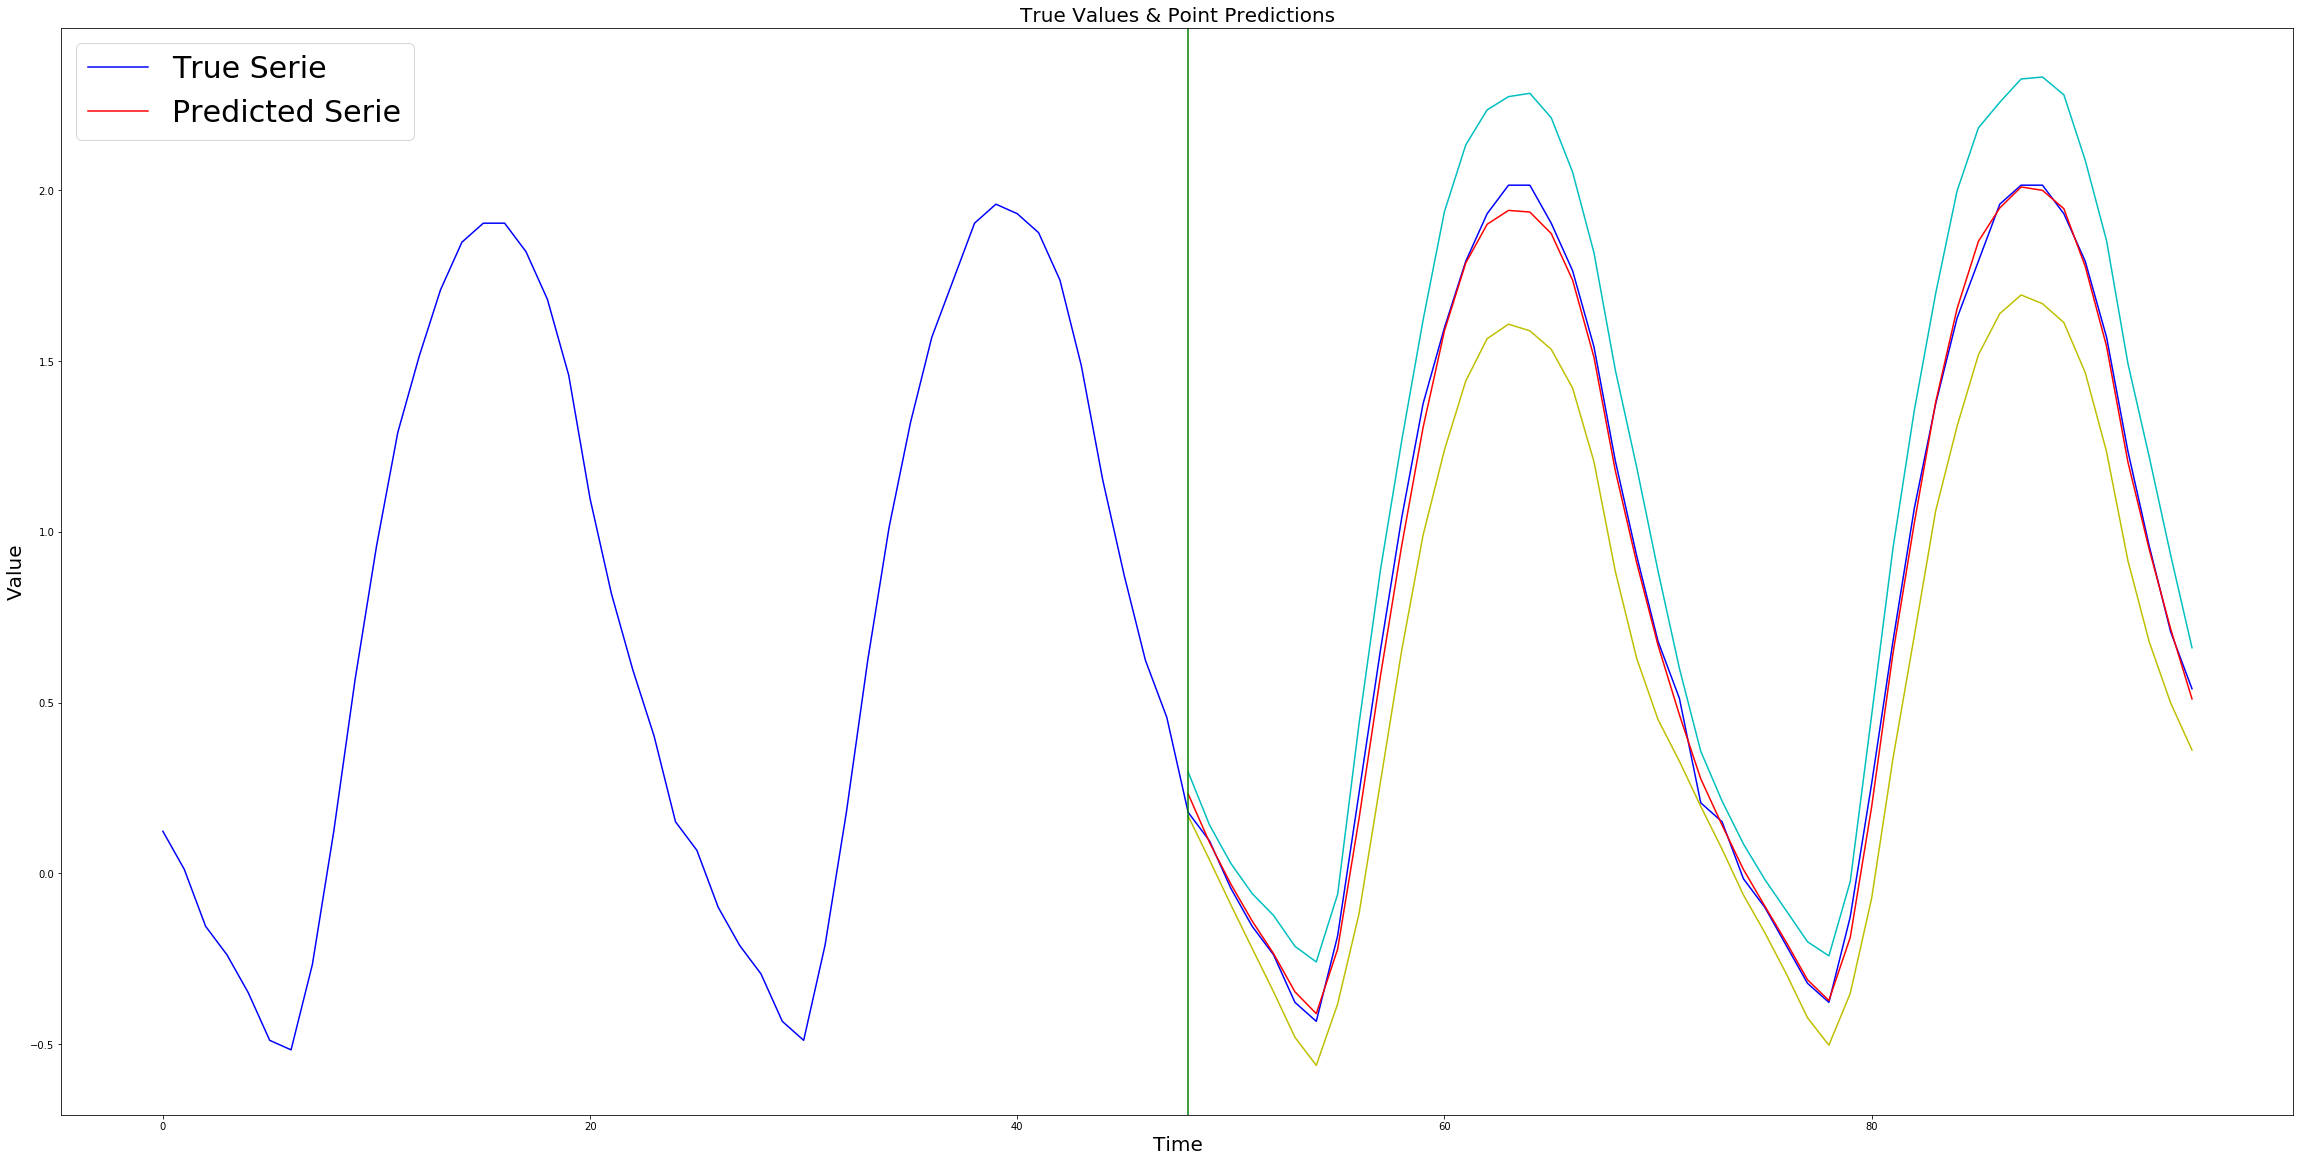

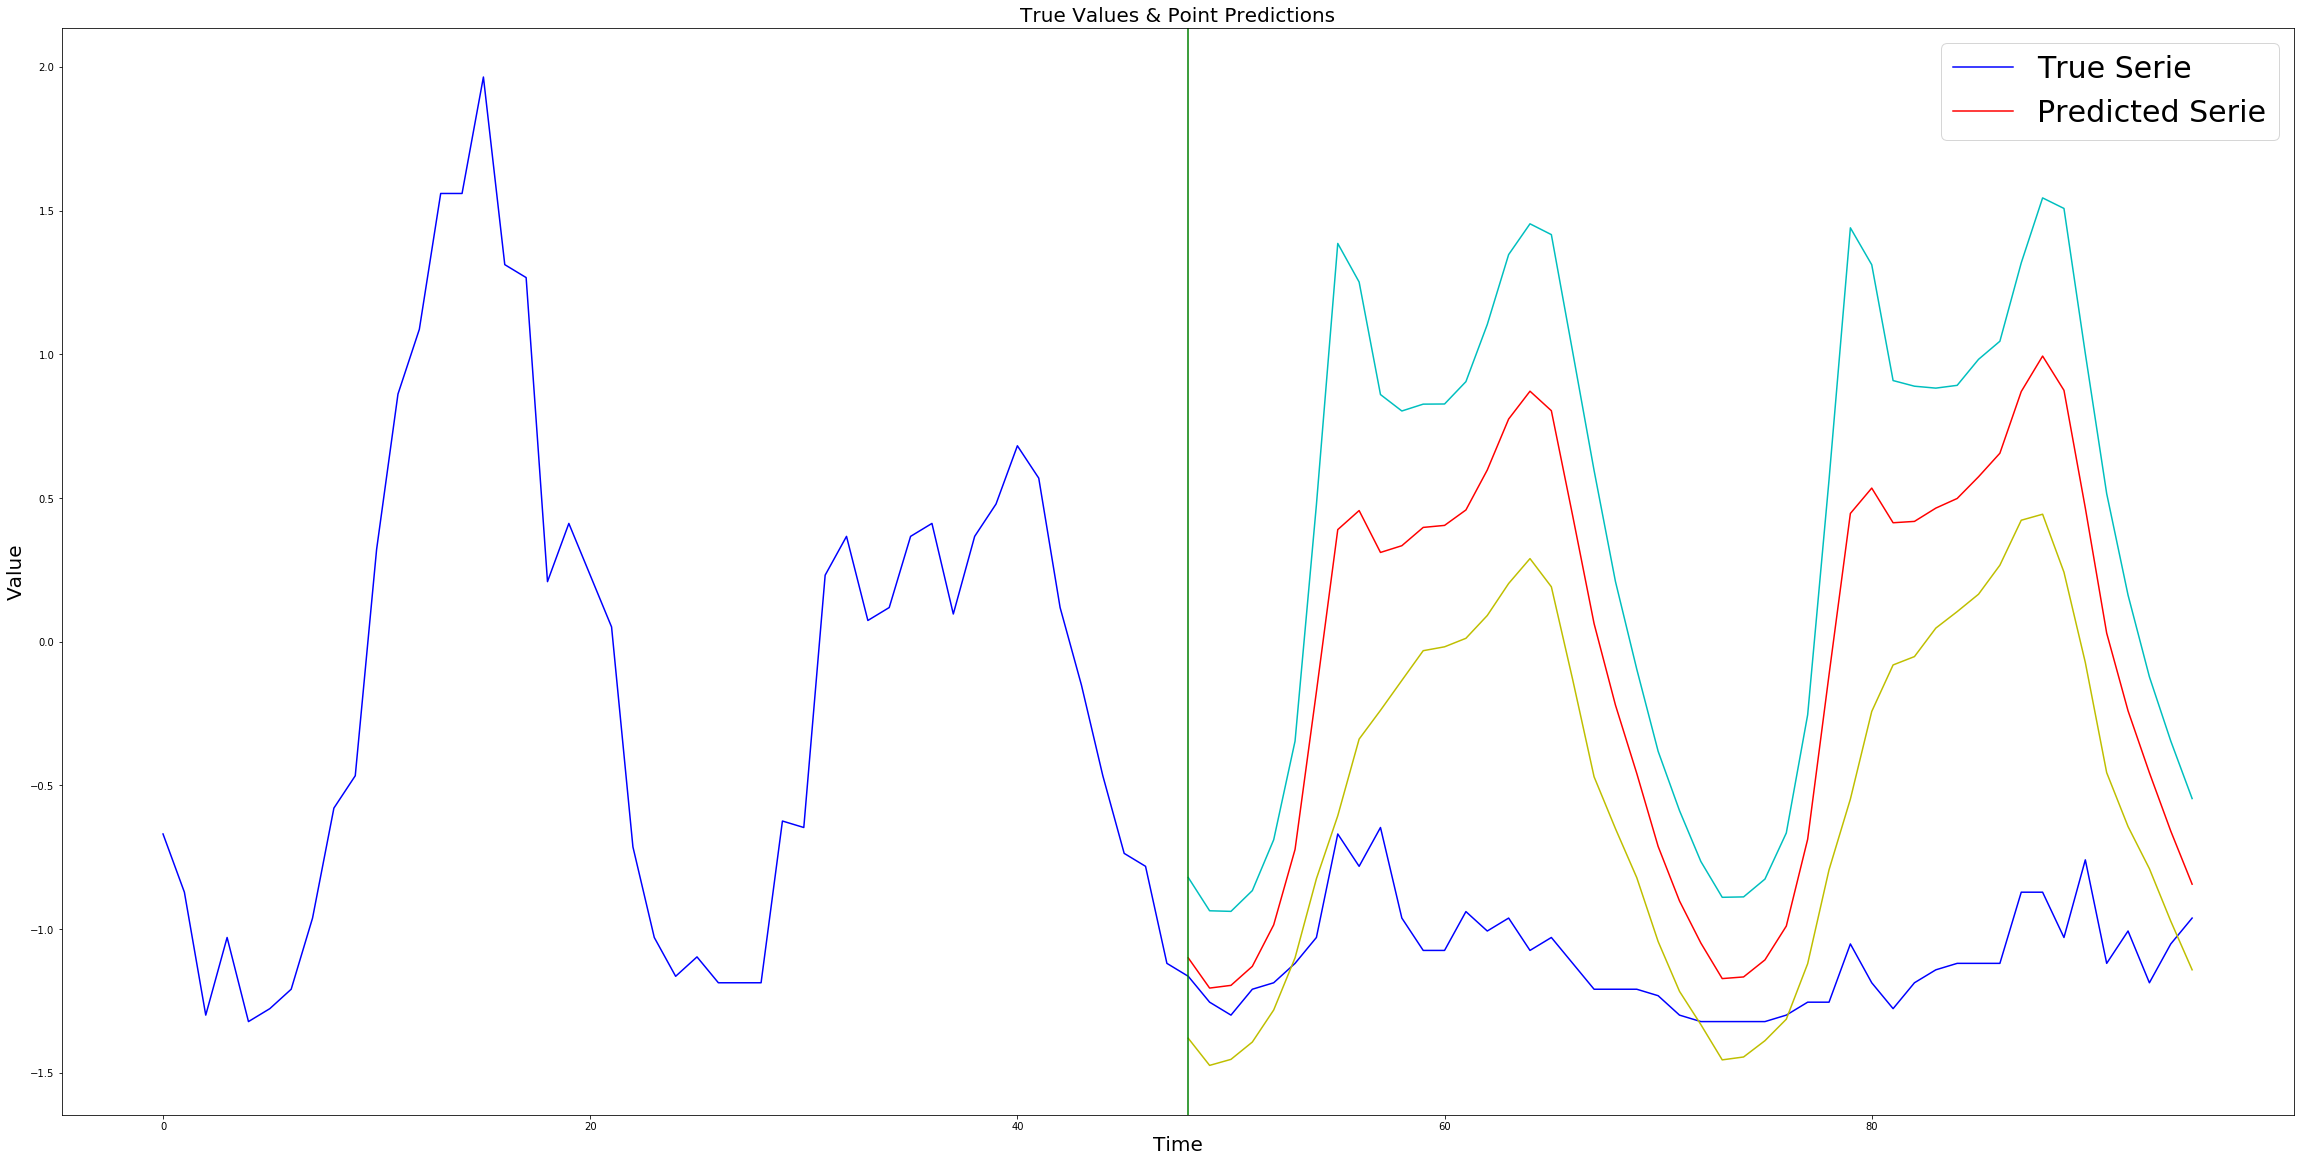

In [6]:
model = M4Model()
model.load('../models/with_kl_pi_params/3-LSTM/7')
#print(hp)

x, y, prediction, error =  sort_by_prediction_error(model,test_x, test_y, mase)

print(f'Best Predection Error is {error[0]:10.4f}')
print(f'Worst Predection Error is {error[x.shape[0]-1]:10.4f}')

lower_bound = prediction[:,:48] - tf.abs(prediction[:,-48:])
upper_bound = prediction[:,:48] + tf.abs(prediction[:,-48:])
plot_serie_with_bounds(x[:,:LOOKBACK,0], y[:,:48], prediction[:,:48], lower_bound, upper_bound, serie_indx=0)
plot_serie_with_bounds(x[:,:LOOKBACK,0], y[:,:48], prediction[:,:48], lower_bound, upper_bound, serie_indx=x.shape[0]-1)

# PLot Specific Serie From A Batch

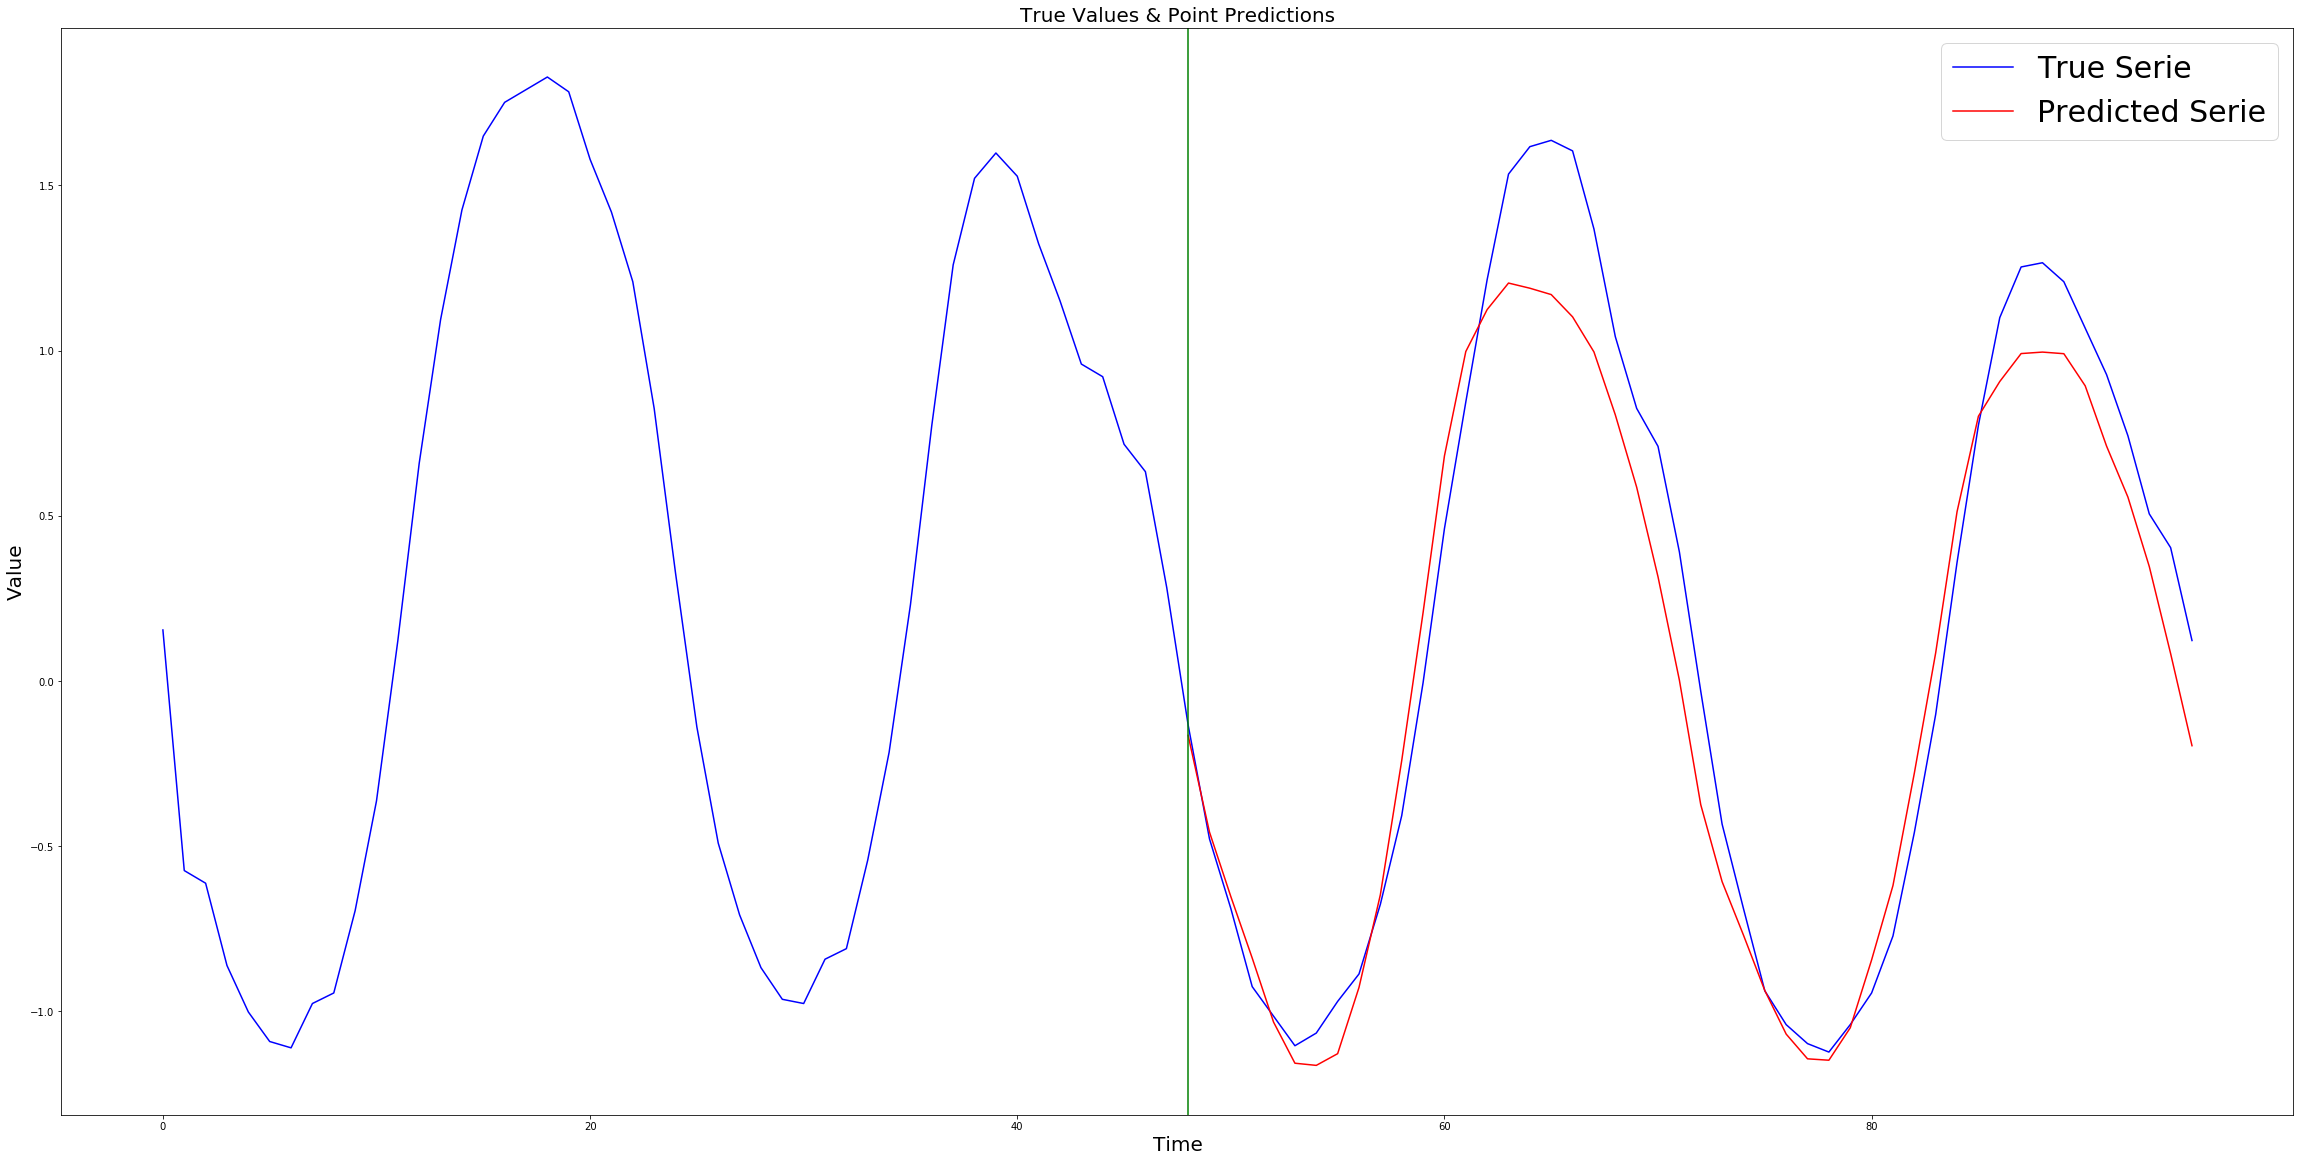

In [8]:
IDX = 0
x = test_x[:BATCH_SIZE,:]
y = test_y[:BATCH_SIZE,:]
#============ Predict Test
predictedY = model.predict(x.reshape(BATCH_SIZE, LOOKBACK, -1 ))
#plot_series(test_x, test_y, predictedY, series_num=10)
plot_serie_and_prediction(x[:,:,0], y[:,:48], predictedY[:,:48], serie_indx=IDX)

# Evaluate A Model Against An Error Function

In [7]:
MODEL_NUMBER = 9
MODEL_BASE_DIR = '../models/with_kl_pi_params/3-LSTM'
hyperparameters, training_error, test_error, validation_error = load_and_evaluate_model(f'{MODEL_BASE_DIR}/{MODEL_NUMBER}', 
                                                                       '../Dataset/Train/Hourly-train.csv', 
                                                                       '../Dataset/Test/Hourly-test.csv', mase)
print(f'Hyperparameters : {hyperparameters}')
print(f'Training Error For Model ({MODEL_NUMBER}) : {training_error}')
print(f'Test Error For Model ({MODEL_NUMBER}) : {test_error}')
print(f'Validation Error For Model ({MODEL_NUMBER}) : {validation_error}')

Loaded model from disk
Hyperparameters : {'epochs': 200, 'batch_size': 128, 'hidden_layer_size': 20, 'lookback': 48, 'loss': 'kl_divergance', 'dropout_ratio': 0.3, 'features_number': 2, 'output_size': 96, 'pi_params': {'max_coff': 0.25, 'min_coff': 0.15, 'step': 0.1}}
Training Error For Model (9) : 0.934
Test Error For Model (9) : 1.035
Validation Error For Model (9) : 1.122


# Evaluate Model PIs

In [10]:
model = M4Model()
model.load('../models/with_kl_pi_params/3-LSTM/5')

y = test_y[:,:HORIZON]
x = test_x[:,:,0]
print(x.shape)

predictedY = model.predict(test_x)
lower_bound = predictedY[:,:HORIZON] - tf.abs(predictedY[:,-HORIZON:])
upper_bound = predictedY[:,:HORIZON] + tf.abs(predictedY[:,-HORIZON:])

print(acd(y, lower_bound.numpy(), upper_bound.numpy()))
print(msis(x, y, lower_bound.numpy(), upper_bound.numpy()))

Loaded model from disk
(394, 48)
0.15283417935702193
12.701019409343838


In [6]:
y = test_y[:,:HORIZON]
lower, upper = naive_pi(y)
print(acd( y[:,:-1], lower, upper))
print(msis(test_x[:,:,0],  y[:,:-1], lower, upper))

0.0462738956690788
15.255543340076647
